# Deep Learning - ¿Gato o perro?
## Entrenamiento de una CNN usando Transfer Learning
En este proyecto, vamos a realizar una tarea de clasificación: Gatos, o perros.

Si bien parece una tarea sencilla, durante la tarea nos enfrentaremos a diversos problemas: ¿Tenemos suficiente variedad en el dataset? ¿Nos podemos permitir entrenamientos de semanas de duración?
Conforme vayamos avanzando, veremos que tenemos a nuestra disposición diversas técnicas que nos permiten lidiar con estos problemas.

A modo de resumen, podemos dividir esta práctica en los siguientes puntos:

   * Obtener y pre-procesar nuestro dataset
   * Variedad adicional en el dataset: Data Augmentation
   * Modelo pre-entrenado: Transfer Learning
      * Elección del modelo base
      * Composición de un modelo final
      * Entrenamiento del modelo
   * Podemos mejorar: Fine-Tuning
   * Conclusiones
   * Bibliografía


Si bien en el índice ya hemos hecho algún spoiler sobre cómo lidiar con los problemas mencionados, profundizaremos en cada punto. Comencemos por obtener nuestro dataset.

# Obtención y pre-procesamiento del dataset

Antes de nada, debemos importar algunas librerías. No debemos alarmarnos por los warning, sólo nos señalan que no tenemos GPU disponible.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

2022-06-11 21:40:01.503969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-11 21:40:01.504005: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Usaremos el dataset de "Gatos Vs Perros" que tenemos disponible en la librería de tensorflow:
https://www.tensorflow.org/datasets/catalog/cats_vs_dogs

Este dataset lo ofrece Microsoft y está vinculado a tensorflow, por tanto podemos cargarlo directamente usando la librería antes importada. Debemos señalar que algunas imágenes vienen erráticas por defecto, lo que nos derivará en algunos warnings a la hora de entrenar. Por suerte, son pocas incidencias y no supone un problema.

Vamos a cargar nuestro dataset y dividirlo en tres partes: Train, validación y test, con un 70, 20 y 10 por ciento del dataset, respectivamente. Puesto que queremos las etiquetas, ponemos como True la flag 'as_supervised'.

Una vez más, tendremos algunos warnings relacionados con la GPU.

In [2]:
(dataset_train, dataset_valid, dataset_test), info = tfds.load('cats_vs_dogs', split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'], as_supervised=True, with_info=True)

2022-06-11 21:40:04.274359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-11 21:40:04.274388: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-11 21:40:04.274406: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (JulioPC): /proc/driver/nvidia/version does not exist
2022-06-11 21:40:04.274655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Vamos a mostrar algo de información adicional sobre nuestro dataset.

In [3]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='~/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and

Antes de continuar, definimos algunas constantes. Puesto que cada imagen viene con una resolución distinta, conviene estandarizar el dataset. Creo que un tamaño adecuado puede ser de 150 por 150 píxeles.

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (150,150)
IMG_SHAPE = IMG_SIZE + (3,)

Como ya sabemos, tenemos dos clases: 'cat' y 'dog'. También tenemos más de 20k imágenes.

In [5]:
class_names = info.features["label"].names
print("Clases: " + str(class_names))
print("Train samples: " + str(len(dataset_train)))
print("Validation samples: " + str(len(dataset_valid)))
print("Test samples: " + str(len(dataset_test)))

Clases: ['cat', 'dog']
Train samples: 16283
Validation samples: 4653
Test samples: 2326


Es hora de pre-procesar nuestro dataset. Como hemos comentado, necesitamos que las imágenes sean de 150x150 píxeles. Aplicaremos por tanto una lambda que haga resize, de forma paralela. También podemos aprovechar y barajar nuestro dataset.

In [6]:
def resize_dataset(dataset, batch_size, img_size):
    dataset = dataset.map(
        lambda x, y: (tf.image.resize(x, img_size), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.shuffle(1000, seed=0)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

Aplicamos a todos nuestros splits

In [7]:
dataset_train = resize_dataset(dataset_train, batch_size=BATCH_SIZE, img_size = IMG_SIZE)
dataset_test = resize_dataset(dataset_test, batch_size=BATCH_SIZE, img_size = IMG_SIZE)
dataset_valid = resize_dataset(dataset_valid, batch_size=BATCH_SIZE, img_size = IMG_SIZE)

Vamos a echar un ojo a qué imágenes tenemos. Podemos apreciar gran variedad de razas, veremos hasta qué punto somos capaces de aprender características.

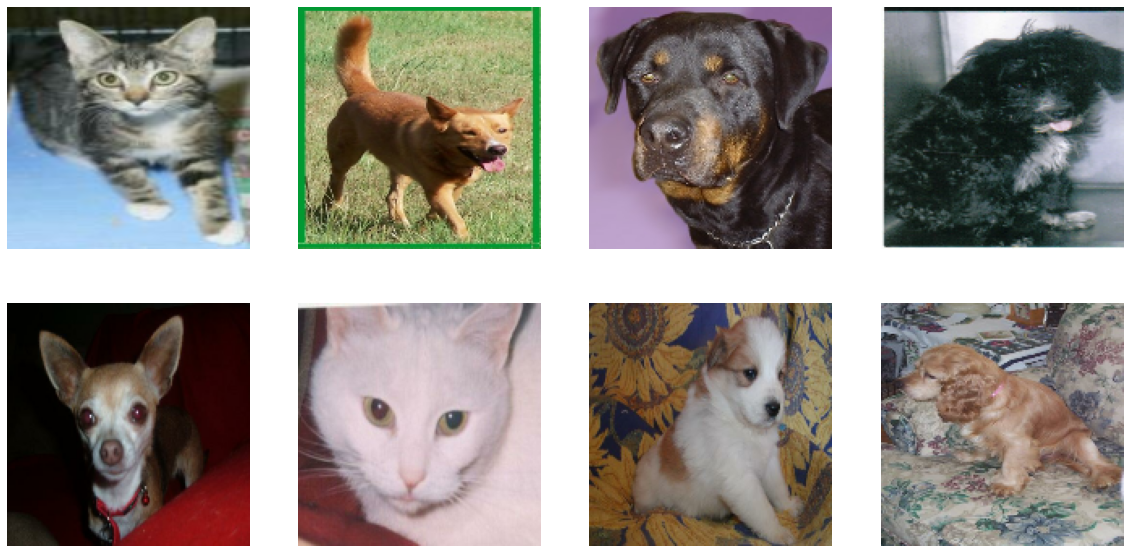

In [8]:
plt.figure(figsize=(20, 10))
images, labels = next(iter(dataset_train))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i] / 255)
    plt.axis("off")
plt.show()

# Variedad adicional en el dataset: Data Augmentation
Cuando tenemos un dataset pequeño, corremos riesgo de overfitting. ¿Qué pasa si no tenemos suficientes ejemplos para entrenar nuestra red?
Una posible solución es la técnica de Data Augmentation, cuya traducción literal es aumentar los datos, pero no de cualquier forma.
Puesto que lo que buscamos es que la CNN aprenda características, podemos pensar que si aplicamos determinados cambios a nuestras imágenes, tendremos características también cambiadas, nuevas, pero que siguen perteneciendo al mismo animal, cambiado.

Es decir, modificamos algunas características para que la red neuronal tenga más variedad a la hora de aprender. Éstos cambios puedne ser voltear la imagen, rotar la imagen, hacer zoom, cambiar contraste y brillo, recortar la imagen...

Vamos a crear una secuencia de capas, que más adelante añadiremos al modelo, con todos los cambios mencionados (excepto crop, puesto que dudo que sea útil), bajo cierta probabilidad.

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

Como una (y ocho) imagen vale más que mil palabras, un buen resumen de lo que hacemos con Data Augmentation puede ser éste:

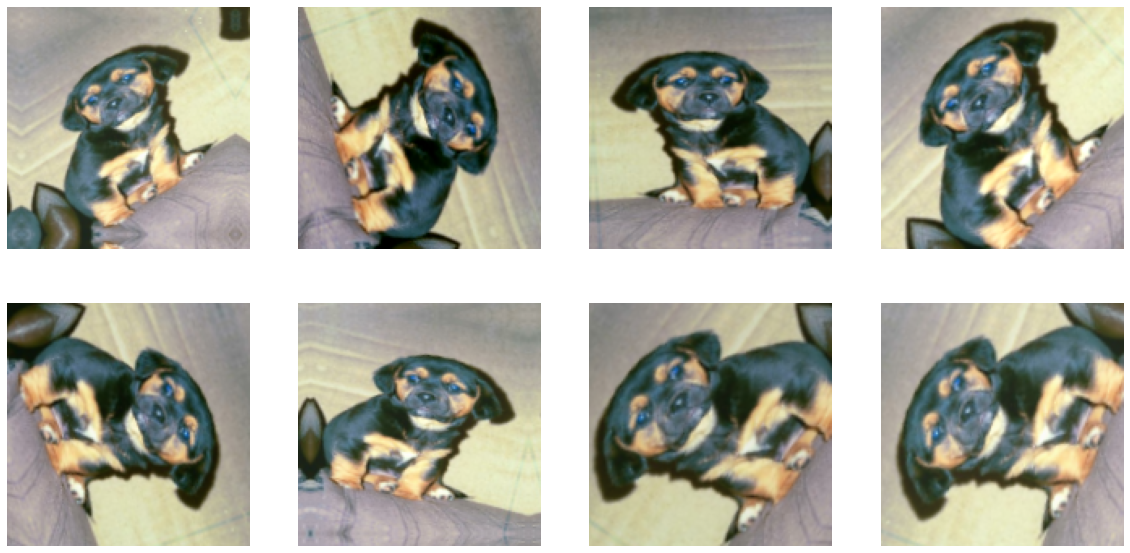

In [10]:
images, labels = next(iter(dataset_train))
image = images[1]

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    augmented_image = data_augmentation(image)
    plt.imshow(augmented_image / 255)
    plt.axis("off")
plt.show()

# Modelo pre-entrenado: Transfer Learning
Si buscamos llevar a cabo una tarea de clasificación pero no tenemos suficientes datos de entrenamiento, o no tenemos suficiente tiempo, a veces es buena idea reusar las capas iniciales de un modelo ya pre-entrenado. Si bien me gusta hacerlo todo por mí mismo, usar esta técnica nos va a ahorrar tanto tiempo de entrenamiento que es prácticamente un **must** en tareas de este tipo. Además de que lo pide el enunciado de la tarea.

Por tanto, elegiremos un modelo que ya haya sido entrenado para problemas similares (obtener características de imágenes), y nos quedaremos con sus capas iniciales. A este modelo base, añadiremos algunas capas en top que se especializarán en nuestra tarea en concreto, en este caso, perros vs gatos.

Entraremos más a detalle más adelante, pero por ahora, ¿qué modelo elegimos?

## Elección de modelo base
Tenemos una lista completa de los modelos a elegir en https://keras.io/api/applications/

Como bien nos dice la descripción de la documentación, esos modelos pueden usarse para predicción, extracción de características y fine-tuning. Justo lo que necesitamos!

Puesto que no disponemos de grandes recursos para entrenar (ni siquiera una GPU), la elección del modelo es fundamental. Debemos elegir uno con buen equilibrio entre performance y tiempo por step de inferencia con CPU.

Una buena elección puede ser **InceptionV3**. Tiene muy buenas puntuaciones, y un tiempo de entrenamiento relativamente pequeño en comparación con sus compañeros.

Si leemos la descripción (https://arxiv.org/abs/1512.00567), los autores nos comentan que es un modelo enfocado a la eficiencia computacional y pocos parámetros a entrenar. Es un modelo que busca apuntar a utilizar el cálculo agregado de la manera más eficiente posible mediante convoluciones adecuadamente factorizadas y una regularización agresiva.

En el desafío de clasificación de ILSVRC 2012, el modelo demostró ganancias sustanciales: 21.2% de error top-1 y 5.6% de error top-5 para la evaluación de un solo frame. Con un conjunto de 4 modelos y una evaluación de cultivos múltiples, obtuvo un 3,5 % de error top-5 en el conjunto de validación (3,6 % de error en el conjunto de prueba) y un 17,3 % de error top-1 en el conjunto de validación.

## Composición del modelo final
Una vez elegido el modelo, vamos a importarlo como modelo base para nuestra CNN, eso sí, descartando las capas superiores.

In [11]:
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False)

De poco serviría importar las capas base de un modelo ya entrenado si modificamos sus pesos en el primer entrenamiento de nuestras capas superiores. Es por ello, que por ahora, congelaremos los pesos. Vamos también a echar un ojo al resumen de este modelo base.

In [12]:
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

Una cosa importante a tener en cuenta es que no sabemos qué imputs permite el modelo. No sabemos si está entrenado para rangos de entre 0 y 1, -1 y 1, 0 y 255... Por suerte estos modelos traen consigo una capa de pre-procesado que hace el trabajo sucio por nosotros.

In [13]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

Vamos a definir las capas superiores que concatenaremos con nuestro modelo base. Éstas capas sí que entrenaremos de 0, por supuesto tendrán mucho ganado ya que tenemos detrás un modelo muy sólido obteniendo características.

Añadiremos, por tanto:

   * Una capa de pooling. He elegido un pooling que haga la media, pero podríamos usar MaxPooling.
   * Una capa de aplanamiento
   * Una capa densa de 256 neuronas, con activación 'relu'
   * Una capa densa de 1 neurona, con activación linear (por defecto): Valores positivos para una clase, y negativos para otra

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
flatten_layer = tf.keras.layers.Flatten()
dense_layer = tf.keras.layers.Dense(256, activation='relu')
prediction_layer = tf.keras.layers.Dense(1)

Una vez tenemos las capas declaradas, es hora de montar nuestro modelo. Comenzamos con las capas de data augmentation, preprocesado del input, y modelo base. Añadiremos encima las capas antes declaradas, las cuales sí entrenaremos, sirviendo de apoyo el modelo base, el cual está congelado.

**Nota**: Como podéis observar, la capa de data augmentation está comentada. Ésto es porque en mi caso, sin encontrar explicación, obtenía un warning diciendo que no coinciden Input shapes: Todas las capas tienen input shape de [None, 150, 150, 3], excepto ésta, la cual tiene [150, 150, 3].
Para mí ha sido un quebradero de cabeza porque al principio no tenía este warning, y no sé que cambio he podido hacer para que de repente no coincidan los inputs. Puesto que no he conseguido solucionarlo, lo he comentado.

En cualquier caso, como observaréis en los resultados finales, tenemos un tamaño del dataset más que suficiente y no es crítico usar data augmentation.

In [15]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = flatten_layer(x)
x = dense_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Ya tenemos nuestro modelo declarado. Vamos a compilarlo, para entrenar las capas superiores. Como learning rate usaremos 0.0001, como optimizador usaremos Adam, y como función de pérdida, pérdida de entropía cruzada.

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

Como vemos en el sumario, pese a tener más de 22 millones de parámetros, sólo entrenaremos 500 mil: El resto ya está entrenado por defecto. Leyendo estas cifras podemos poner de manifiesto la utilidad del transfer learning.

## Entrenamiento del modelo
Vamos a entrenar nuestro modelo. En principio, usaremos cinco etapas. Puesto que hay algunas imágenes erráticas, obtendremos algunos warnings.

In [18]:
initial_epochs = 5
history = model.fit(dataset_train, epochs=initial_epochs, validation_data=dataset_valid)

Epoch 1/5
135/509 [======>.......................] - ETA: 2:53 - loss: 0.1910 - accuracy: 0.9238

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


172/509 [=========>....................] - ETA: 2:36 - loss: 0.1768 - accuracy: 0.9304

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/509 [=============>................] - ETA: 2:05 - loss: 0.1577 - accuracy: 0.9388

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/509 [=======================>......] - ETA: 40s - loss: 0.1404 - accuracy: 0.9478

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


443/509 [=========================>....] - ETA: 31s - loss: 0.1374 - accuracy: 0.9489

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


465/509 [==========================>...] - ETA: 21s - loss: 0.1352 - accuracy: 0.9497

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


471/509 [==========================>...] - ETA: 18s - loss: 0.1338 - accuracy: 0.9503

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


509/509 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9508

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


509/509 [==============================] - 311s 602ms/step - loss: 0.1316 - accuracy: 0.9508 - val_loss: 0.0900 - val_accuracy: 0.9684
Epoch 2/5
135/509 [======>.......................] - ETA: 2:28 - loss: 0.0818 - accuracy: 0.9697

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


172/509 [=========>....................] - ETA: 2:15 - loss: 0.0834 - accuracy: 0.9691

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/509 [=============>................] - ETA: 1:52 - loss: 0.0870 - accuracy: 0.9672

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/509 [=======================>......] - ETA: 38s - loss: 0.0859 - accuracy: 0.9672

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


443/509 [=========================>....] - ETA: 30s - loss: 0.0853 - accuracy: 0.9673

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


465/509 [==========================>...] - ETA: 20s - loss: 0.0846 - accuracy: 0.9675

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


471/509 [==========================>...] - ETA: 17s - loss: 0.0848 - accuracy: 0.9675

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


509/509 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9678

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


509/509 [==============================] - 300s 589ms/step - loss: 0.0835 - accuracy: 0.9678 - val_loss: 0.0826 - val_accuracy: 0.9697
Epoch 3/5
135/509 [======>.......................] - ETA: 2:54 - loss: 0.0726 - accuracy: 0.9713

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


172/509 [=========>....................] - ETA: 2:39 - loss: 0.0683 - accuracy: 0.9724

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/509 [=============>................] - ETA: 2:07 - loss: 0.0715 - accuracy: 0.9717

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/509 [=======================>......] - ETA: 40s - loss: 0.0734 - accuracy: 0.9717

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


443/509 [=========================>....] - ETA: 31s - loss: 0.0730 - accuracy: 0.9721

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


465/509 [==========================>...] - ETA: 21s - loss: 0.0716 - accuracy: 0.9729

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


471/509 [==========================>...] - ETA: 18s - loss: 0.0718 - accuracy: 0.9729

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


509/509 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9727

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


509/509 [==============================] - 300s 589ms/step - loss: 0.0722 - accuracy: 0.9727 - val_loss: 0.0806 - val_accuracy: 0.9693
Epoch 4/5
135/509 [======>.......................] - ETA: 2:17 - loss: 0.0592 - accuracy: 0.9766

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


172/509 [=========>....................] - ETA: 2:08 - loss: 0.0665 - accuracy: 0.9744

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/509 [=============>................] - ETA: 1:49 - loss: 0.0688 - accuracy: 0.9729

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/509 [=======================>......] - ETA: 37s - loss: 0.0675 - accuracy: 0.9736

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


443/509 [=========================>....] - ETA: 29s - loss: 0.0671 - accuracy: 0.9739

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


465/509 [==========================>...] - ETA: 19s - loss: 0.0660 - accuracy: 0.9743

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


471/509 [==========================>...] - ETA: 17s - loss: 0.0661 - accuracy: 0.9742

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


509/509 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9746

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


509/509 [==============================] - 294s 578ms/step - loss: 0.0654 - accuracy: 0.9746 - val_loss: 0.0974 - val_accuracy: 0.9590
Epoch 5/5
135/509 [======>.......................] - ETA: 2:54 - loss: 0.0580 - accuracy: 0.9778

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


172/509 [=========>....................] - ETA: 2:36 - loss: 0.0617 - accuracy: 0.9766

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/509 [=============>................] - ETA: 2:02 - loss: 0.0619 - accuracy: 0.9758

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/509 [=======================>......] - ETA: 36s - loss: 0.0584 - accuracy: 0.9773

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


443/509 [=========================>....] - ETA: 27s - loss: 0.0576 - accuracy: 0.9777

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


465/509 [==========================>...] - ETA: 18s - loss: 0.0571 - accuracy: 0.9781

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


471/509 [==========================>...] - ETA: 15s - loss: 0.0568 - accuracy: 0.9782

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


509/509 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9781

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


509/509 [==============================] - 269s 529ms/step - loss: 0.0567 - accuracy: 0.9781 - val_loss: 0.0837 - val_accuracy: 0.9669


Vemos que el entrenamiento ha dado resultados excelentes: Aciertos de casi un 98% en el set de entrenamiento y casi un 97% en el set de validación.

In [19]:
def plotAccuracy(history, acc = [], val_acc = []):
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']

    plt.figure(figsize=(20, 5))
    plt.plot(acc, label='Accuracy (Entrenamiento)')
    plt.plot(val_acc, label='Accuracy (Validación)')
    plt.legend(loc='upper left')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.title('Accuracy')
    plt.show()

    return acc, val_acc


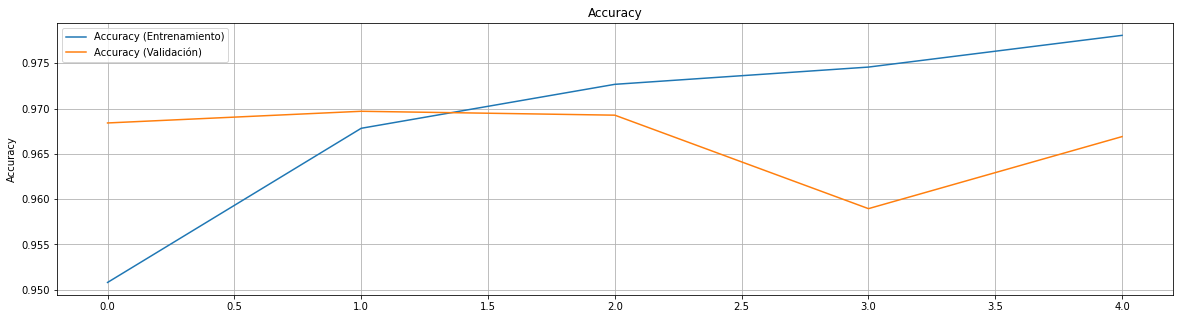

In [20]:
acc, val_acc = plotAccuracy(history)

# Fine-Tuning
Estos resultados son muy buenos, pero, ¿podemos mejorarlos algo más?

Vamos a recapitular: Tenemos unas primeras capas, pre-entrenadas para extracción de características de imágenes genéricas, que funcionan de forma excelente. También tenemos, concatenadas, unas últimas capas especializadas en distinguir entre gatos y perros.

Los pesos de las primeras capas los congelamos porque ya nos venían entrenados, pero, ¿qué pasaría si descongelamos estos pesos, y entrenamos un poco más toda la red para que no sólo las últimas capas se enfoquen en perros y gatos, si no también lo hagan estas primeras capas?

Ésto es lo que se conoce como Fine-Tuning.

Si bien suena genial, hay que tomar algunas precauciones. Primero, debemos usar un learning rate mucho más pequeño, para no "cargarnos" el modelo base importado. Buscamos (muy) pequeñas variaciones, no grandes cambios.
Segundo, es buena práctica no entrenar todas las capas del modelo base. Sólo entrenaremos las cien superiores, dejando las más iniciales tal como están.

Con estas dos anotaciones minimizamos riesgos de perder lo ganado tras la importación del modelo pre-entrenado. Recordemos que este paso es la guinda del pastel, los cambios deben ser sutiles.

In [21]:
print("Número de capas del modelo base: ", len(base_model.layers))

Número de capas del modelo base:  311


In [22]:
base_model.trainable = True
fine_tuning_start = 100
for layer in base_model.layers[:fine_tuning_start]:
    layer.trainable = False

Compilamos el modelo. Esta vez usamos RMSprop, como optimizador, y un learning rate diez veces más pequeño que el original.

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

Tenemos el modelo compilado, vamos a seguir entrenando donde lo dejamos.

In [25]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(dataset_train, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=dataset_valid)


Epoch 5/10
135/509 [======>.......................] - ETA: 6:50 - loss: 0.0541 - accuracy: 0.9785

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


172/509 [=========>....................] - ETA: 6:14 - loss: 0.0555 - accuracy: 0.9793

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/509 [=============>................] - ETA: 5:08 - loss: 0.0539 - accuracy: 0.9793

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/509 [=======================>......] - ETA: 1:38 - loss: 0.0536 - accuracy: 0.9802

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


443/509 [=========================>....] - ETA: 1:16 - loss: 0.0526 - accuracy: 0.9806

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


465/509 [==========================>...] - ETA: 50s - loss: 0.0516 - accuracy: 0.9810

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


471/509 [==========================>...] - ETA: 44s - loss: 0.0515 - accuracy: 0.9810

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


509/509 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9810

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


509/509 [==============================] - 669s 1s/step - loss: 0.0520 - accuracy: 0.9810 - val_loss: 0.0740 - val_accuracy: 0.9742
Epoch 6/10
135/509 [======>.......................] - ETA: 7:00 - loss: 0.0163 - accuracy: 0.9937

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


172/509 [=========>....................] - ETA: 6:18 - loss: 0.0181 - accuracy: 0.9933

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/509 [=============>................] - ETA: 4:54 - loss: 0.0159 - accuracy: 0.9939

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/509 [=======================>......] - ETA: 1:30 - loss: 0.0141 - accuracy: 0.9947

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


443/509 [=========================>....] - ETA: 1:10 - loss: 0.0140 - accuracy: 0.9947

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


465/509 [==========================>...] - ETA: 46s - loss: 0.0142 - accuracy: 0.9948

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


471/509 [==========================>...] - ETA: 40s - loss: 0.0141 - accuracy: 0.9948

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


509/509 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9949

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


509/509 [==============================] - 601s 1s/step - loss: 0.0137 - accuracy: 0.9949 - val_loss: 0.0881 - val_accuracy: 0.9766
Epoch 7/10
135/509 [======>.......................] - ETA: 6:29 - loss: 0.0058 - accuracy: 0.9984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


172/509 [=========>....................] - ETA: 5:49 - loss: 0.0062 - accuracy: 0.9984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/509 [=============>................] - ETA: 4:38 - loss: 0.0060 - accuracy: 0.9981

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/509 [=======================>......] - ETA: 1:27 - loss: 0.0054 - accuracy: 0.9979

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


443/509 [=========================>....] - ETA: 1:08 - loss: 0.0052 - accuracy: 0.9980

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


465/509 [==========================>...] - ETA: 45s - loss: 0.0051 - accuracy: 0.9981

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


471/509 [==========================>...] - ETA: 39s - loss: 0.0050 - accuracy: 0.9981

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


509/509 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9982

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


509/509 [==============================] - 586s 1s/step - loss: 0.0048 - accuracy: 0.9982 - val_loss: 0.1191 - val_accuracy: 0.9772
Epoch 8/10
135/509 [======>.......................] - ETA: 6:24 - loss: 0.0016 - accuracy: 0.9995

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


172/509 [=========>....................] - ETA: 5:45 - loss: 0.0016 - accuracy: 0.9995

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/509 [=============>................] - ETA: 4:34 - loss: 0.0020 - accuracy: 0.9994

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/509 [=======================>......] - ETA: 1:31 - loss: 0.0022 - accuracy: 0.9993

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


443/509 [=========================>....] - ETA: 1:11 - loss: 0.0022 - accuracy: 0.9992

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


465/509 [==========================>...] - ETA: 47s - loss: 0.0021 - accuracy: 0.9993

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


471/509 [==========================>...] - ETA: 41s - loss: 0.0020 - accuracy: 0.9993

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


509/509 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9991

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


509/509 [==============================] - 620s 1s/step - loss: 0.0023 - accuracy: 0.9991 - val_loss: 0.1685 - val_accuracy: 0.9770
Epoch 9/10
135/509 [======>.......................] - ETA: 7:05 - loss: 0.0013 - accuracy: 0.9993

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


172/509 [=========>....................] - ETA: 6:16 - loss: 0.0018 - accuracy: 0.9991

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/509 [=============>................] - ETA: 5:01 - loss: 0.0013 - accuracy: 0.9994

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/509 [=======================>......] - ETA: 1:37 - loss: 0.0019 - accuracy: 0.9993

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


443/509 [=========================>....] - ETA: 1:16 - loss: 0.0019 - accuracy: 0.9993

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


465/509 [==========================>...] - ETA: 50s - loss: 0.0018 - accuracy: 0.9993

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


471/509 [==========================>...] - ETA: 43s - loss: 0.0018 - accuracy: 0.9993

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


509/509 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9993

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


509/509 [==============================] - 652s 1s/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.1627 - val_accuracy: 0.9789
Epoch 10/10
135/509 [======>.......................] - ETA: 7:10 - loss: 8.4729e-04 - accuracy: 0.9998

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


172/509 [=========>....................] - ETA: 6:27 - loss: 6.7901e-04 - accuracy: 0.9998

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/509 [=============>................] - ETA: 5:08 - loss: 9.2946e-04 - accuracy: 0.9995

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/509 [=======================>......] - ETA: 1:37 - loss: 6.2780e-04 - accuracy: 0.9997

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


443/509 [=========================>....] - ETA: 1:15 - loss: 6.0089e-04 - accuracy: 0.9997

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


465/509 [==========================>...] - ETA: 50s - loss: 5.7258e-04 - accuracy: 0.9997

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


471/509 [==========================>...] - ETA: 43s - loss: 5.6528e-04 - accuracy: 0.9997

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


509/509 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9997

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


509/509 [==============================] - 649s 1s/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.2099 - val_accuracy: 0.9781


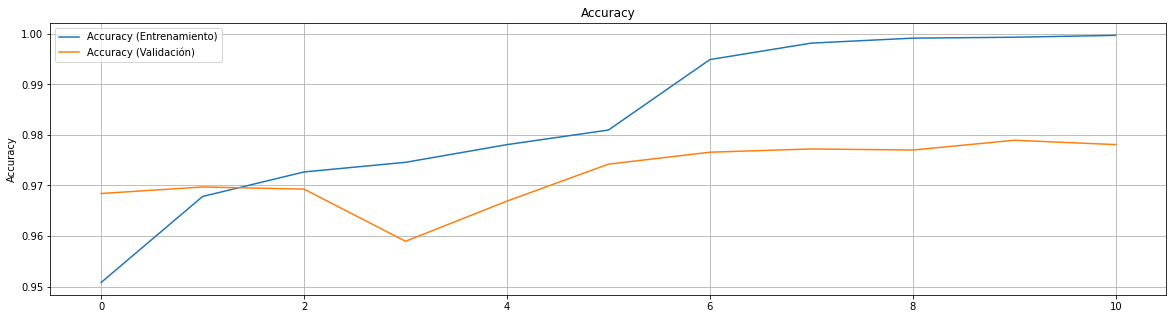

In [26]:
a, v = plotAccuracy(history_fine)

Arriba tenemos la evolución a lo largo del entrenamiento fine-tuning. Vamos a ver abajo una gráfica completa, concatenando el primer entrenamiento con este último.

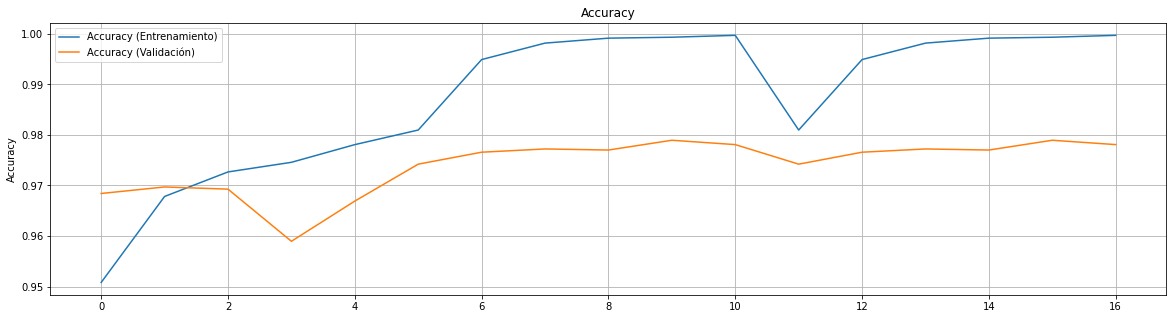

In [27]:
a, v = plotAccuracy(history_fine, acc, val_acc)

Una precisión de casi el 100%, y una pérdida prácticamente despreciable... ¿Hemos encontrado el modelo perfecto, o simplemente es overfitting? Vamos a comprobarlo.

In [28]:
loss, accuracy = model.evaluate(dataset_test)
print('Test accuracy:', accuracy)

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 30s 413ms/step - loss: 0.1358 - accuracy: 0.9862
Test accuracy: 0.9862424731254578


Una puntuación en test de más del 98%! Es una puntuación extraordinaria. Quizás hayamos tenido un poco de overfitting, pero nada grave.

Vemos que hemos obtenido un modelo excelente. Por supuesto no mejora al ser humano, pero tampoco podemos decir que sea mucho peor.

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


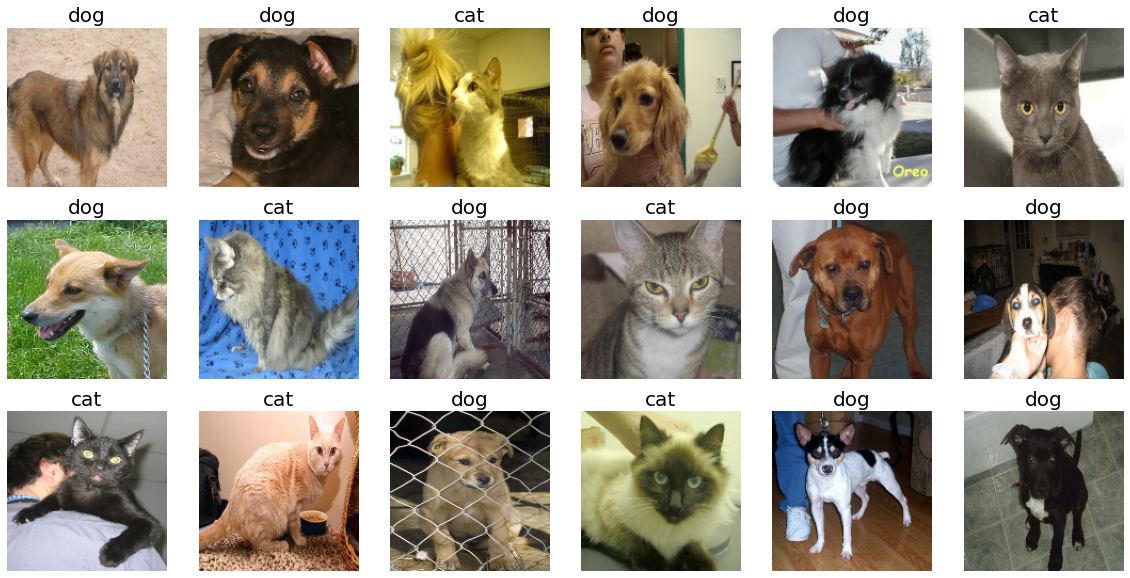

In [29]:
image_batch, label_batch = dataset_test.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

plt.figure(figsize=(20, 10))
for i in range(18):
    ax = plt.subplot(3, 6, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]], fontsize=20)
    plt.axis("off")


# Conclusiones

Como opinión personal, me parece un proyecto muy interesante. Es elegante, útil y no es complejo. Creo que el transfer learning es una técnica que muchos no conocemos, o conocemos pero no nos planteamos explotarlo. En mi caso, lo conocía por haberlo leído en algunos libros, pero no imaginaba que iba a ser tan potente y útil. Conocerlo de primera mano creo que es un acierto, además de que nos ayuda a interiorizar mejor los conceptos de capas y extracción de características. Además de que, si tenemos problemas en un paso concreto, internet está lleno de guías sobre este tema que nos pueden servir de apoyo para no atascarnos.

Como punto en contra, podría decir que quizás hubiera estado mejor elegir otro dataset más complejo, ya vemos que los resultados son excelentes y no ha supuesto demasiado reto encontrar modelos que funcionen. Claro que usando modelos pre-entrenados de tal calibre es difícil tener modelos que no funcionen medianamente bien.

# Bibliografía

   * Dataset: Cats Vs Dogs: https://www.tensorflow.org/datasets/catalog/cats_vs_dogs
   * Comparativa de modelos base: https://keras.io/api/applications/
   * Modelo base elegido:
      * https://keras.io/api/applications/inceptionv3/
      * https://arxiv.org/abs/1512.00567
   * Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow